Nama : Suwandi Ramadhan

# Project 3 - Voice Recognition

## Data & Algoritma Understanding

## Model Training & Evaluation

#### Import Library

In [17]:
# Install dan Import Library
!pip install datasets librosa torch torchaudio soundfile scikit-learn jiwer matplotlib -q

import os, random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.preprocessing import OneHotEncoder
from datasets import load_dataset, Audio
from jiwer import wer, cer
from collections import Counter
from difflib import SequenceMatcher

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
# Konfigurasi Pertama
LANG = 'en-US'
SAMPLE_RATE = 16000
N_MFCC = 13
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4

In [19]:
# # Konfigurasi Kedua
# LANG = 'en-US'
# SAMPLE_RATE = 16000
# N_MFCC = 26
# BATCH_SIZE = 32
# NUM_EPOCHS = 80
# LEARNING_RATE = 1e-5

In [20]:
# # Konfigurasi Ketiga
# LANG = 'en-US'
# SAMPLE_RATE = 16000
# N_MFCC = 26
# BATCH_SIZE = 64
# NUM_EPOCHS = 100

In [21]:
# Load dataset & split
raw_dataset = load_dataset("PolyAI/minds14", LANG, trust_remote_code=True)

# Split data: 70% train, 15% validation, 15% test
train_test_split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
train_data = train_test_split['train']
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
val_data = test_valid_split['train']
test_data = test_valid_split['test']

# Pastikan audio dikonversi ke sample rate yang sesuai
train_data = train_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))
val_data = val_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))
test_data = test_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))

print(f"Ukuran data train: {len(train_data)}")
print(f"Ukuran data validasi: {len(val_data)}")
print(f"Ukuran data test: {len(test_data)}")

Ukuran data train: 394
Ukuran data validasi: 84
Ukuran data test: 85


In [22]:
# Token mapping + OneHotEncoder
transcript_col = "transcription" # Kolom transkripsi
tokens = sorted(list(set(c for ex in train_data for c in ex[transcript_col].lower())))
char2idx = {c: i for i, c in enumerate(tokens)}
idx2char = {i: c for i, c in enumerate(tokens)}

# Tambahkan token 'blank' untuk CTC loss di akhir vocab
char2idx['<blank>'] = len(tokens)
idx2char[len(tokens)] = '<blank>'
BLANK_TOKEN_ID = char2idx['<blank>']
vocab_size = len(char2idx)

print(f"Ukuran Vocab: {vocab_size}")

# Buat ulang OHE dengan vocab yang sudah menyertakan token blank
all_tokens = list(char2idx.keys())
ohe = OneHotEncoder(sparse_output=False, categories=[all_tokens], handle_unknown='ignore')
ohe.fit(np.array(all_tokens).reshape(-1, 1))

Ukuran Vocab: 42


,categories,"[[' ', '$', ...]]"
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [23]:
# Hitung Statistik Normalisasi dari Data Training
print("Menghitung statistik normalisasi dari seluruh data training...")
all_mfccs_list = []
for example in train_data:
    audio, sr = librosa.load(example['audio']['path'], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC).T
    all_mfccs_list.append(mfcc)

all_mfccs_np = np.vstack(all_mfccs_list)
mfcc_mean = np.mean(all_mfccs_np, axis=0)
mfcc_std = np.std(all_mfccs_np, axis=0)
print("Statistik normalisasi selesai dihitung.")

Menghitung statistik normalisasi dari seluruh data training...
Statistik normalisasi selesai dihitung.


In [24]:
# Memfilter Data yang Tidak Memenuhi Syarat CTC

def is_valid_sample(sample):
    """
    Memeriksa apakah sebuah sampel audio valid untuk training CTC.
    Panjang output model (setelah downsampling) harus >= panjang label.
    """
    # hop_length default librosa untuk MFCC adalah 512
    # Perkirakan panjang spektogram MFCC
    spec_len = len(sample['audio']['array']) // 512 + 1
    
    # Faktor downsampling model adalah 2x dari model yang disederhanakan nanti
    DOWNSAMPLING_FACTOR = 2
    logit_len = spec_len // DOWNSAMPLING_FACTOR
    
    # Panjang label teks (transkripsi)
    label_len = len(sample['transcription'])
    
    return logit_len >= label_len

print("Memfilter data training...")
original_train_len = len(train_data)
train_data_filtered = train_data.filter(is_valid_sample)
filtered_train_len = len(train_data_filtered)
print(f"Ukuran data train asli: {original_train_len}, setelah difilter: {filtered_train_len}. ({original_train_len - filtered_train_len} sampel dibuang)")

print("\nMemfilter data validasi...")
original_val_len = len(val_data)
val_data_filtered = val_data.filter(is_valid_sample)
filtered_val_len = len(val_data_filtered)
print(f"Ukuran data validasi asli: {original_val_len}, setelah difilter: {filtered_val_len}. ({original_val_len - filtered_val_len} sampel dibuang)")

print("\nMemfilter data test...")
original_test_len = len(test_data)
test_data_filtered = test_data.filter(is_valid_sample)
filtered_test_len = len(test_data_filtered)
print(f"Ukuran data test asli: {original_test_len}, setelah difilter: {filtered_test_len}. ({original_test_len - filtered_test_len} sampel dibuang)")

Memfilter data training...
Ukuran data train asli: 394, setelah difilter: 387. (7 sampel dibuang)

Memfilter data validasi...
Ukuran data validasi asli: 84, setelah difilter: 84. (0 sampel dibuang)

Memfilter data test...
Ukuran data test asli: 85, setelah difilter: 85. (0 sampel dibuang)


In [25]:
# Augmentasi & SpecAugment
def augment(audio, sr):
    noise = np.random.randn(len(audio)) * 0.005
    audio_with_noise = audio + noise
    stretch_rate = random.uniform(0.9, 1.1)
    audio_stretched = librosa.effects.time_stretch(audio_with_noise, rate=stretch_rate)
    pitch_steps = random.randint(-2, 2)
    audio_final = librosa.effects.pitch_shift(audio_stretched, sr=sr, n_steps=pitch_steps)
    return audio_final

def spec_augment(mfcc):
    t, f = mfcc.shape
    time_mask_num = random.randint(10, 25)
    if t > time_mask_num:
        time_mask_start = random.randint(0, t - time_mask_num)
        mfcc[time_mask_start:time_mask_start + time_mask_num, :] = 0
    
    freq_mask_num = random.randint(2, 5)
    if f > freq_mask_num:
        freq_mask_start = random.randint(0, f - freq_mask_num)
        mfcc[:, freq_mask_start:freq_mask_start + freq_mask_num] = 0
        
    return mfcc

In [26]:
# Dataset & Collate (dengan data yang sudah difilter)

class SpeechDataset(Dataset):
    def __init__(self, data, mean, std, augment_prob=0.5):
        self.data = data
        self.mean = mean
        self.std = std + 1e-5
        self.augment_prob = augment_prob
        self.transcript_col = "transcription"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]
        audio_array = ex['audio']['array']
        sr = ex['audio']['sampling_rate']
        
        # Menggunakan audio array langsung
        if random.random() < self.augment_prob:
            audio_array = augment(audio_array, sr)
            
        mfcc = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=N_MFCC).T
        mfcc = (mfcc - self.mean) / self.std
        
        if random.random() < 0.5 and self.augment_prob > 0:
            mfcc = spec_augment(mfcc)
            
        return mfcc, ex[self.transcript_col].lower()

def collate_fn(batch):
    specs, texts = zip(*batch)
    spec_lengths = [s.shape[0] for s in specs]
    max_spec_len = max(spec_lengths)
    
    # Padding MFCC/Spectrogram
    padded_specs = [np.pad(s, ((0, max_spec_len - s.shape[0]), (0, 0)), mode='constant') for s in specs]
    X = torch.tensor(padded_specs, dtype=torch.float32)

    # Padding Target/Label
    targets, target_lengths = [], []
    for t in texts:
        # Konversi karakter ke integer
        chars_as_ints = [char2idx[c] for c in t]
        targets.extend(chars_as_ints)
        target_lengths.append(len(chars_as_ints))
        
    # Return target sebagai flat tensor
    y_flat = torch.tensor(targets, dtype=torch.long)
    y_lens = torch.tensor(target_lengths, dtype=torch.long)
        
    return X, torch.tensor(spec_lengths), y_flat, y_lens

# Gunakan data yang sudah difilter
train_dataset = SpeechDataset(train_data_filtered, mfcc_mean, mfcc_std, augment_prob=0.5)
val_dataset = SpeechDataset(val_data_filtered, mfcc_mean, mfcc_std, augment_prob=0.0)
test_dataset = SpeechDataset(test_data_filtered, mfcc_mean, mfcc_std, augment_prob=0.0)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)

In [27]:
# Model BiLSTM

class CNNBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, n_mfcc, rnn_dim=128, rnn_layers=2, dropout=0.15):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, stride=(2, 2)), 
            nn.GELU(),
            nn.BatchNorm2d(32), # Tambah BatchNorm untuk stabilitas
            nn.Dropout(dropout)
        )
        # Hitung ukuran output frekuensi dari Conv layer 
        conv_out_freq = (n_mfcc + 2 * 1 - 3) // 2 + 1
        rnn_input_size = 32 * conv_out_freq
        
        self.rnn = nn.LSTM(rnn_input_size, rnn_dim, num_layers=rnn_layers, 
                           bidirectional=True, batch_first=True, dropout=dropout)
        self.norm = nn.LayerNorm(rnn_dim * 2)
        self.fc = nn.Linear(rnn_dim * 2, vocab_size)

    def forward(self, x, lengths):
        x = x.unsqueeze(1) # -> (batch, 1, time, freq)
        x = self.conv(x)   # -> (batch, 32, time/2, freq/2)
        
        b, c, t, f = x.size()
        x = x.permute(0, 2, 1, 3).contiguous() # -> (batch, time/2, 32, freq/2)
        x = x.view(b, t, c * f) # -> (batch, time/2, 32*freq/2)
        
        # Panjang sekuens berkurang 2x karena stride Conv=(2,2)
        lengths = torch.floor_divide(lengths, 2).cpu() 
        
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(packed)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        
        unpacked = self.norm(unpacked)
        logits = self.fc(unpacked)
        
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNBiLSTMModel(vocab_size=vocab_size, n_mfcc=N_MFCC).to(device)
print(model)
# Cek rnn_input_size yang baru
print(f"\nUkuran input yang diharapkan oleh RNN: {model.rnn.input_size}")

CNNBiLSTMModel(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.15, inplace=False)
  )
  (rnn): LSTM(224, 128, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=42, bias=True)
)

Ukuran input yang diharapkan oleh RNN: 224


In [28]:
# Training & Evaluasi

import torch.nn.functional as F

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, 
                                          steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)
criterion = nn.CTCLoss(blank=BLANK_TOKEN_ID, zero_infinity=True)
scaler = GradScaler(enabled=torch.cuda.is_available())

def greedy_decode(logits):
    pred_ids = torch.argmax(logits.log_softmax(dim=-1), dim=-1)
    results = []
    for seq in pred_ids:
        prev_char_id = -1
        decoded_seq = []
        for char_id in seq:
            if char_id != prev_char_id and char_id != BLANK_TOKEN_ID:
                decoded_seq.append(idx2char.get(char_id.item(), ''))
            prev_char_id = char_id
        results.append(''.join(decoded_seq))
    return results

def evaluate(loader):
    model.eval()
    all_preds, all_refs = [], []
    with torch.no_grad():
        for X, spec_lens, y_flat, y_lens in loader:
            X = X.to(device)
            with autocast(device_type=device.type, enabled=torch.cuda.is_available()):
                logits = model(X, spec_lens.cpu())
            
            preds = greedy_decode(logits.cpu())
            
            idx = 0
            for length in y_lens:
                ref_seq = y_flat[idx:idx+length]
                all_refs.append(''.join([idx2char[int(c)] for c in ref_seq]))
                idx += length
            
            all_preds.extend(preds)
            
    return wer(all_refs, all_preds), cer(all_refs, all_preds)

train_losses, val_cers, val_wers = [], [], []
best_cer = float('inf')
epochs_no_improve = 0
patience = 5  # Berhenti setelah 5 epoch tidak ada perbaikan

DOWNSAMPLING_FACTOR = 2

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for X, spec_lens, y_flat, y_lens in train_loader:
        X, y_flat, y_lens = X.to(device), y_flat.to(device), y_lens.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            logits = model(X, spec_lens.cpu())
            log_probs = F.log_softmax(logits, dim=-1)
            log_probs_permuted = log_probs.permute(1, 0, 2)
            logit_lens = torch.floor_divide(spec_lens, DOWNSAMPLING_FACTOR).to(device)
            loss = criterion(log_probs_permuted, y_flat, logit_lens, y_lens)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    val_wer, val_cer = evaluate(val_loader)
    
    train_losses.append(avg_train_loss)
    val_wers.append(val_wer)
    val_cers.append(val_cer)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Loss {avg_train_loss:.4f}, Val WER {val_wer:.3f}, Val CER {val_cer:.3f}")
    
    # --- LOGIKA EARLY STOPPING ---
    if val_cer < best_cer:
        best_cer = val_cer
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Model terbaik disimpan ke best_model.pth (CER: {best_cer:.3f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"❌ Tidak ada perbaikan. Counter: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"\n✋ Early stopping dipicu setelah {epoch+1} epoch.")
        break

Epoch 1/100: Loss 6.4842, Val WER 1.000, Val CER 0.966
✅ Model terbaik disimpan ke best_model.pth (CER: 0.966)
Epoch 2/100: Loss 6.4841, Val WER 1.000, Val CER 0.972
❌ Tidak ada perbaikan. Counter: 1/5
Epoch 3/100: Loss 6.3150, Val WER 1.000, Val CER 0.978
❌ Tidak ada perbaikan. Counter: 2/5
Epoch 4/100: Loss 6.2432, Val WER 1.000, Val CER 0.966
✅ Model terbaik disimpan ke best_model.pth (CER: 0.966)
Epoch 5/100: Loss 6.0034, Val WER 1.000, Val CER 0.945
✅ Model terbaik disimpan ke best_model.pth (CER: 0.945)
Epoch 6/100: Loss 5.7709, Val WER 1.000, Val CER 0.932
✅ Model terbaik disimpan ke best_model.pth (CER: 0.932)
Epoch 7/100: Loss 5.4573, Val WER 1.000, Val CER 0.918
✅ Model terbaik disimpan ke best_model.pth (CER: 0.918)
Epoch 8/100: Loss 5.0408, Val WER 1.003, Val CER 0.895
✅ Model terbaik disimpan ke best_model.pth (CER: 0.895)
Epoch 9/100: Loss 4.7717, Val WER 1.003, Val CER 0.874
✅ Model terbaik disimpan ke best_model.pth (CER: 0.874)
Epoch 10/100: Loss 4.4209, Val WER 1.002,


Final Test WER: 0.996, Final Test CER: 0.860


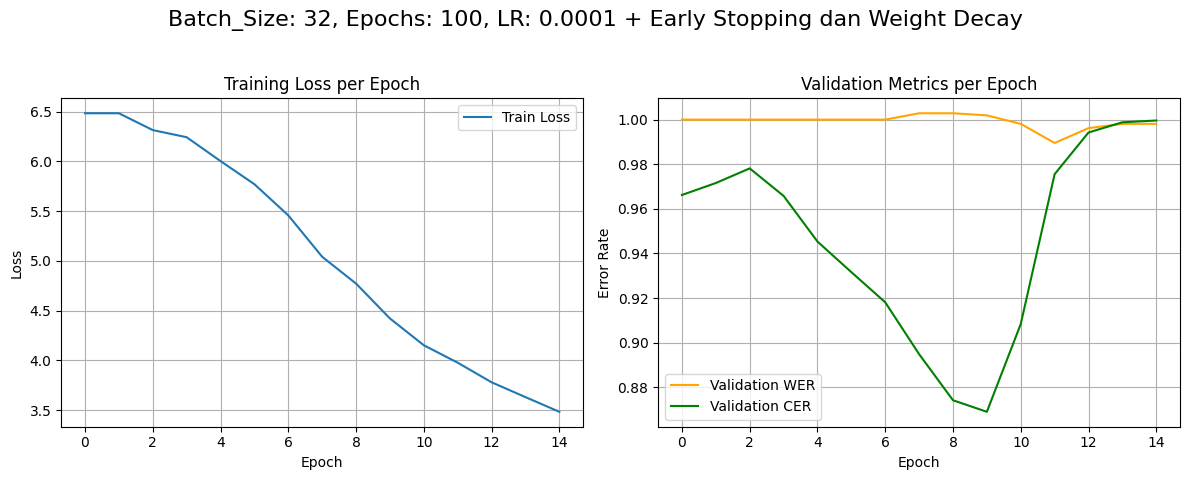

In [29]:
# Evaluasi akhir pada test set
# Evaluasi model terbaik
model.load_state_dict(torch.load("best_model.pth"))
final_wer, final_cer = evaluate(test_loader)
print(f"\nFinal Test WER: {final_wer:.3f}, Final Test CER: {final_cer:.3f}")

# Plotting hasil training
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Batch_Size: {BATCH_SIZE}, Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE} + Early Stopping dan Weight Decay", fontsize=16)

# --- Training Loss ---
axs[0].plot(train_losses, label='Train Loss')
axs[0].set_title('Training Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# --- Validation Metrics ---
axs[1].plot(val_wers, label='Validation WER', color='orange')
axs[1].plot(val_cers, label='Validation CER', color='green')
axs[1].set_title('Validation Metrics per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Error Rate')
axs[1].legend()
axs[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Sesuaikan agar suptitle tidak tumpang tindih
plt.show()

In [30]:
# Analisis Error (Disesuaikan)

def predict_and_analyze(loader):
    model.eval()
    all_preds, all_refs = [], []
    with torch.no_grad():
        # y_flat, y_lens didapat dari loader baru
        for X, spec_lens, y_flat, y_lens in loader:
            X = X.to(device)
            logits = model(X, spec_lens.cpu())
            preds = greedy_decode(logits.cpu())
            
            # Mendekode referensi dari y_flat
            idx = 0
            for length in y_lens:
                ref_seq = y_flat[idx:idx+length]
                all_refs.append(''.join([idx2char[int(c)] for c in ref_seq]))
                idx += length
            
            all_preds.extend(preds)
            
    return pd.DataFrame({"Reference": all_refs, "Prediction": all_preds})

# Muat kembali model terbaik sebelum analisis
model.load_state_dict(torch.load("best_model.pth"))
results_df = predict_and_analyze(test_loader)
results_df.to_csv("predictions.csv", index=False)
print("Prediksi disimpan ke predictions.csv")

# Analisis Error Karakter (kode ini tidak perlu diubah)
char_errors = Counter()
for _, row in results_df.iterrows():
    ref, hyp = row['Reference'], row['Prediction']
    matcher = SequenceMatcher(None, ref, hyp)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            for r, h in zip(ref[i1:i2], hyp[j1:j2]): char_errors[f"{r}→{h}"] += 1
        elif tag == 'delete':
            for r in ref[i1:i2]: char_errors[f"{r}→-"] += 1
        elif tag == 'insert':
            for h in hyp[j1:j2]: char_errors[f"-→{h}"] += 1

print("\n15 Kesalahan Karakter Paling Umum:")
for err, count in char_errors.most_common(15):
    print(f"{err}: {count}x")

Prediksi disimpan ke predictions.csv

15 Kesalahan Karakter Paling Umum:
 →-: 321x
e→-: 151x
a→-: 145x
t→-: 141x
o→-: 139x
n→-: 129x
i→-: 112x
m→-: 79x
s→-: 68x
d→-: 66x
r→-: 65x
h→-: 53x
y→-: 50x
-→ : 49x
g→-: 48x
